# I. Importing

In [26]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint



# II. Loading data set

In [27]:
# === STEP 2: Load and Filter Dataset (Unbalanced) ===
#DATA_DIR = r'D:\NIH Xray Dataset'
DATA_DIR = r'C:\Users\thick\Downloads\archive' # Customize where the original dataset is located
CSV_PATH = os.path.join(DATA_DIR, 'Data_Entry_2017.csv')
IMG_SIZE = 224
target_classes = ['Atelectasis', 'Consolidation', 'Edema', 'Fibrosis', 'No Finding']

In [28]:
def preprocess_image(file_name):
    file_path = find_image_path(file_name, DATA_DIR)
    # DEBUG----------------------------
    print(f"[INFO] Processing image: {file_name} from {file_path}")
    if file_path:
        img = cv2.imread(file_path)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = cv2.GaussianBlur(img, (5, 5), 0)
        return img
    print(f"[WARN] Image not found: {file_name}")
    return np.zeros((IMG_SIZE, IMG_SIZE, 3))  # fallback: black image

In [29]:
target_labels = [label for label in target_classes if label != "No Finding"]
target_labels

['Atelectasis', 'Consolidation', 'Edema', 'Fibrosis']

#  III. Sampling the Dataset

With respect to images with No finding, the images selected in sampling will be in ratio to the ones with no finding. Labels with 'Atelectasis', 'Consolidation', 'Edema', and 'Fibrosis'

In [31]:
df = pd.read_csv(CSV_PATH)
df['Finding Labels'] = df['Finding Labels'].str.strip()
df_filtered = df[df['Finding Labels'].isin(target_classes)].copy()

# Optional: Display class distribution before balancing
print("Class distribution before balancing:")
print(df_filtered['Finding Labels'].value_counts())

# Encode labels
df_filtered['label_code'] = pd.Categorical(df_filtered['Finding Labels'], categories=target_classes).codes

# === STEP 3: Apply Weighted Sampling ===
# Ratios are kept for each samples. 0.04% is set as minimum for the smallest samples
sample_weights = df_filtered['Finding Labels'].map(
    lambda x: len(x.split('|')) if len(x) > 0 else 0
).values + 4e-2

sample_weights /= sample_weights.sum()

df_sampled = df_filtered.sample(
    56060, 
    weights=sample_weights, 
    replace=True,  # allow oversampling
    random_state=42
)

print("\nClass distribution AFTER weighted sampling:")
print(df_sampled['Finding Labels'].value_counts())

# === STEP 4: Image Path Helper ===
def find_image_path(file_name, base_dir):
    for i in range(1, 13):
        sub_dir = os.path.join(base_dir, f'images_{i:03d}', 'images')
        file_path = os.path.join(sub_dir, file_name)
        if os.path.exists(file_path):
            return file_path
    return None

Class distribution before balancing:
Finding Labels
No Finding       60361
Atelectasis       4215
Consolidation     1310
Fibrosis           727
Edema              628
Name: count, dtype: int64

Class distribution AFTER weighted sampling:
Finding Labels
No Finding       50324
Atelectasis       3502
Consolidation     1095
Fibrosis           629
Edema              510
Name: count, dtype: int64


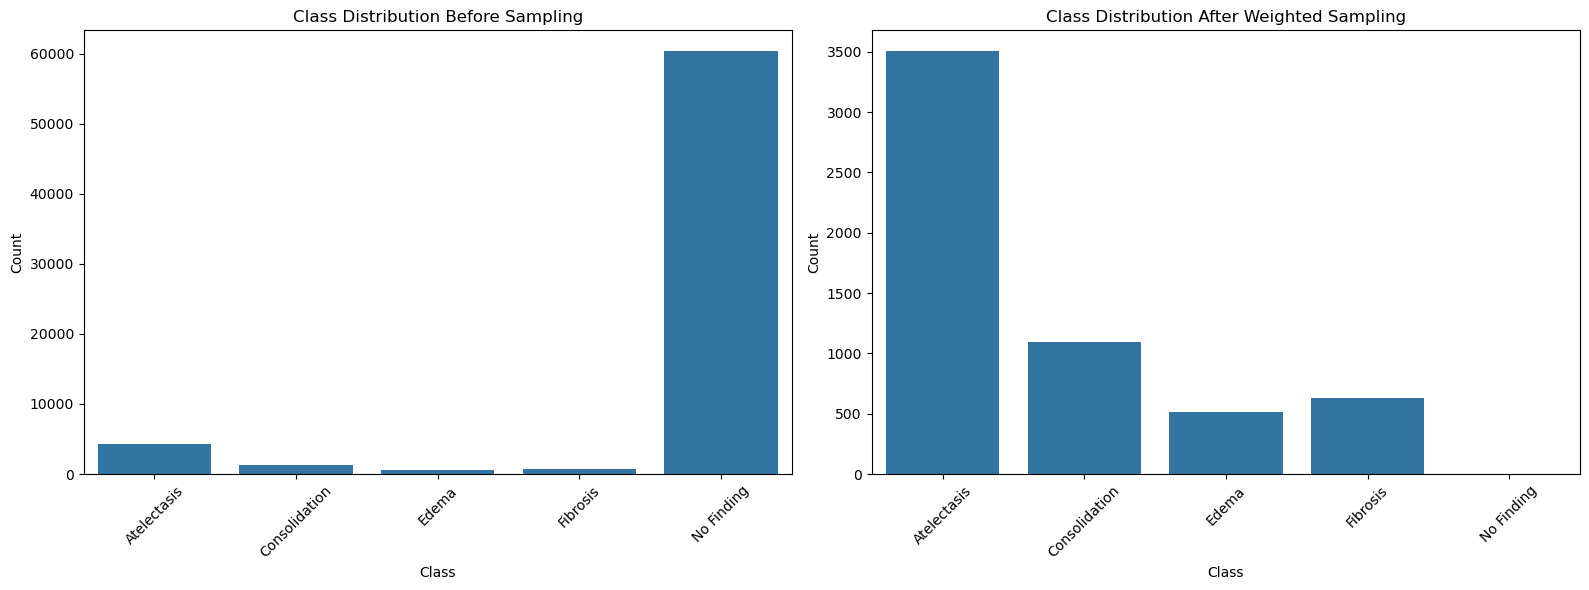

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot original class distribution (counts)
sns.barplot(x=original_counts.index, y=original_counts.values, ax=axes[0], hue=None)
axes[0].set_title('Class Distribution Before Sampling')
axes[0].set_ylabel('Count')
axes[0].set_xlabel('Class')
axes[0].tick_params(axis='x', rotation=45)

# Plot sampled class distribution (counts)
sns.barplot(x=sampled_counts.index, y=sampled_counts.values, ax=axes[1], hue=None)
axes[1].set_title('Class Distribution After Weighted Sampling')
axes[1].set_ylabel('Count')
axes[1].set_xlabel('Class')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


C:\Users\thick\AppData\Local\Temp\ipykernel_35272\2302030613.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=weights_per_class.index, y=weights_per_class.values, palette='coolwarm', hue=None, legend=False)


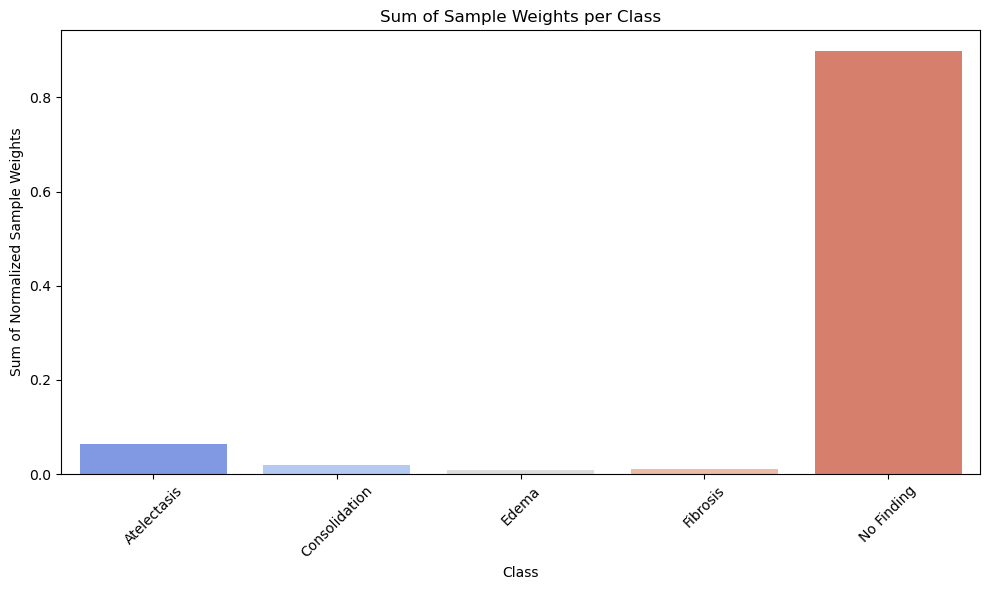

In [75]:
# Create a DataFrame with labels and their corresponding sample weights
df_weights = pd.DataFrame({
    'Finding Labels': df_filtered['Finding Labels'],
    'Sample Weight': sample_weights
})

# Group by label and sum weights per class
weights_per_class = df_weights.groupby('Finding Labels')['Sample Weight'].sum()

# Reindex to maintain order of target_classes
weights_per_class = weights_per_class.reindex(target_classes)

# Plotting
plt.figure(figsize=(10,6))
sns.barplot(x=weights_per_class.index, y=weights_per_class.values, palette='coolwarm', hue=None, legend=False)
plt.title('Sum of Sample Weights per Class')
plt.ylabel('Sum of Normalized Sample Weights')
plt.xlabel('Class')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [32]:
# 2. Remove rows where "Finding Labels" == "No Finding"
df_sampled = df_sampled[df_filtered['Finding Labels'] != "No Finding"]

C:\Users\thick\AppData\Local\Temp\ipykernel_35272\2568556547.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=weights_per_class.index, y=weights_per_class.values, palette='coolwarm')


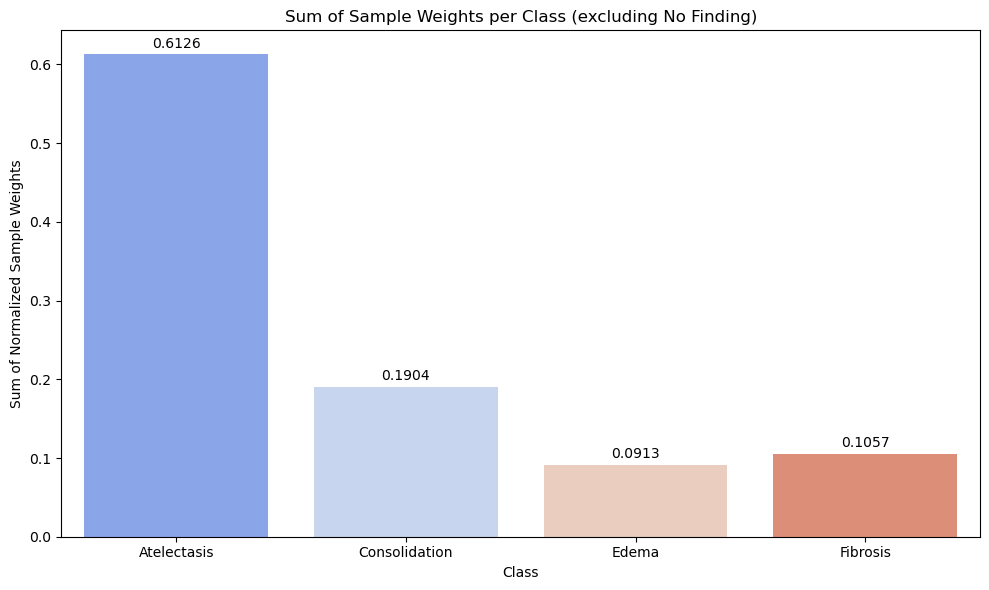

In [79]:
# Create DataFrame with labels and weights (from df_filtered without No Finding)
df_weights = pd.DataFrame({
    'Finding Labels': df_filtered['Finding Labels'],
    'Sample Weight': sample_weights
})

# Exclude 'No Finding' rows from df_weights
df_weights = df_weights[df_weights['Finding Labels'] != "No Finding"]

# Group by label and sum weights per class
weights_per_class = df_weights.groupby('Finding Labels')['Sample Weight'].sum()

# Reindex to maintain order of target_classes but exclude 'No Finding'
target_classes_no_nf = [cls for cls in target_classes if cls != "No Finding"]
weights_per_class = weights_per_class.reindex(target_classes_no_nf)

# Plotting
plt.figure(figsize=(10,6))
ax = sns.barplot(x=weights_per_class.index, y=weights_per_class.values, palette='coolwarm')
plt.title('Sum of Sample Weights per Class (excluding No Finding)')
plt.ylabel('Sum of Normalized Sample Weights')
plt.xlabel('Class')
plt.xticks(rotation=0)

# Annotate values on top of bars
for i, val in enumerate(weights_per_class.values):
    ax.text(i, val + 0.005, f'{val:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


In [33]:
df_sampled.shape

(5736, 13)

# IV. Image Preprocessing

The preprocessing includes resizing the image to 224 and sharpen and normalize the features of the X-ray images to look good.

In [34]:
def preprocess_image_clahe(file_name):
    file_path = find_image_path(file_name, DATA_DIR)
    if not file_path:
        print(f"Missing: {file_name}")
        return np.zeros((IMG_SIZE, IMG_SIZE, 3))
    
    img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    
    # Step 1: Resize
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    
    # Step 2: CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img = clahe.apply(img)

    # Step 3: Sharpen (optional)
    kernel = np.array([[0, -1, 0],
                       [-1, 5, -1],
                       [0, -1, 0]])
    img = cv2.filter2D(img, -1, kernel)

    # Step 4: Normalize
    img = img / 255.0

    # Step 5: Convert to 3 channels 
    img = np.stack([img]*3, axis=-1)

    return img

In [35]:
# === STEP 4: Preprocess All Images and Labels ===

# Convert labels to integer indices
label_to_index = {label: idx for idx, label in enumerate(target_labels)}
df_sampled['Label Index'] = df_sampled['Finding Labels'].map(label_to_index)
### DEBUG: Check label mapping
print("Label mapping:")
# Preprocess images
images = np.array([preprocess_image_clahe(fname) for fname in df_sampled['Image Index']])
labels = to_categorical(df_sampled['Label Index'].values, num_classes=len(target_labels))
print(f"[INFO] Total images: {images.shape}, Labels: {labels.shape}")

Label mapping:
[INFO] Total images: (5736, 224, 224, 3), Labels: (5736, 4)


Note: once preprocessed and booting up the python notebook simply boot up the images in a zip file

In [39]:
save_path = r'C:\Users\thick\Downloads\XrayClassificationCNN'
np.savez_compressed(os.path.join(save_path, 'ACEF_data_compressed_finalData_sampled.npz'),
                    images=images, labels=labels)
# Access Saved files via this comment above line
#data = np.load('ACEF_data_compressed_finalData.npz')
#images = data['images']
#labels = data['labels']

# V. Train Test Split

In [40]:

# === STEP 5: Train-Test Split ===

# 25% of entire dataset for final test
X_temp, X_test, y_temp, y_test = train_test_split(images, labels, test_size=0.25, stratify=labels, random_state=42)

# Split remaining 25% into train and validation
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42)


print(f"[INFO] Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

[INFO] Train: (3226, 224, 224, 3), Val: (1076, 224, 224, 3), Test: (1434, 224, 224, 3)


In [41]:
df_sampled.shape

(5736, 14)

# VI. Data Augmenting

In [42]:
# === STEP 6: Data Augmentation ===
train_aug = ImageDataGenerator(
    rotation_range=5,
    width_shift_range=0.1,
    height_shift_range=0.05,
    shear_range = 0.1,
    zoom_range=0.15,
    fill_mode = 'reflect',
    horizontal_flip=True,
    vertical_flip = False
)

val_aug = ImageDataGenerator()  # No augmentation for val/test

Adding more data to final traiuning

In [43]:
# Store originals
X_train_original = X_train.copy()
y_train_original = y_train.copy()

augmented_images = []
augmented_labels = []

# How many augmentations added to original
num_aug = 1

for i in range(len(X_train_original)):
    img = X_train_original[i]
    label = y_train_original[i]

    # Add augmented copies
    for _ in range(num_aug):
        aug_img = train_aug.random_transform(img)  # Apply augmentation
        augmented_images.append(aug_img)
        augmented_labels.append(label)

# Convert augmented lists to arrays
augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

# Combine original + augmented
X_train_final = np.concatenate([X_train_original, augmented_images], axis=0)
y_train_final = np.concatenate([y_train_original, augmented_labels], axis=0)

print("Final training set size:", X_train_final.shape, y_train_final.shape)

Final training set size: (6452, 224, 224, 3) (6452, 4)


# VII. Model Training

In [45]:
# === STEP 7: Build MobileNetV2 CNN ===

base_model = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze base model

inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(4, activation='softmax')(x)


model = Model(inputs, outputs)
model.compile(optimizer=Adam(learning_rate=0.0003), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_2   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 batch_normalization_2 (Batc  (None, 1280)             5120      
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 256)               327936    
                                                           

# VIII. Training the Model

In [46]:
X_train_final.shape


(6452, 224, 224, 3)

In [47]:
# === STEP 8: Train Model ===
BATCH_SIZE = 128
EPOCHS = 20
 

# Use X_train_final or y_train_final for the augmented set
history = model.fit(
    X_train_final, y_train_final,
    validation_data=(X_val, y_val),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    shuffle=True
)


Epoch 1/20
51/51 [==============================] - 61s 1s/step - loss: 1.4019 - accuracy: 0.5062 - val_loss: 0.9851 - val_accuracy: 0.6208
Epoch 2/20
51/51 [==============================] - 52s 1s/step - loss: 1.0490 - accuracy: 0.6094 - val_loss: 0.8944 - val_accuracy: 0.6543
Epoch 3/20
51/51 [==============================] - 52s 1s/step - loss: 0.8867 - accuracy: 0.6544 - val_loss: 0.8562 - val_accuracy: 0.6747
Epoch 4/20
51/51 [==============================] - 52s 1s/step - loss: 0.7914 - accuracy: 0.6857 - val_loss: 0.8338 - val_accuracy: 0.6812
Epoch 5/20
51/51 [==============================] - 52s 1s/step - loss: 0.7162 - accuracy: 0.7213 - val_loss: 0.8238 - val_accuracy: 0.6794
Epoch 6/20
51/51 [==============================] - 52s 1s/step - loss: 0.6530 - accuracy: 0.7443 - val_loss: 0.8063 - val_accuracy: 0.6998
Epoch 7/20
51/51 [==============================] - 52s 1s/step - loss: 0.5965 - accuracy: 0.7633 - val_loss: 0.8062 - val_accuracy: 0.6840
Epoch 8/20
51/51 [==

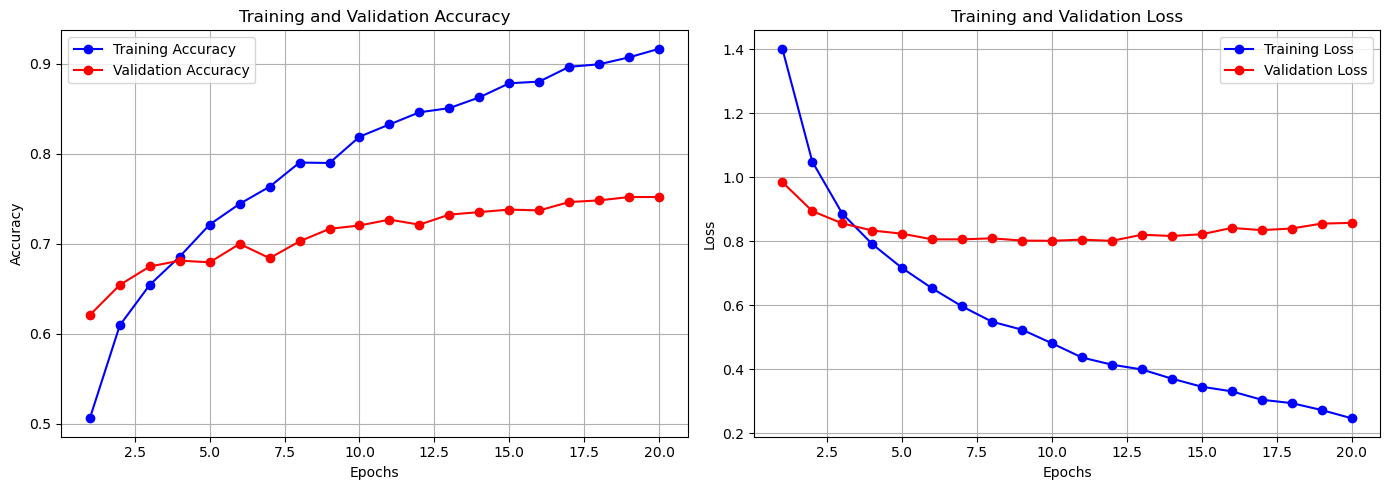

In [56]:
import matplotlib.pyplot as plt

# Extract metrics from history
acc = history.history.get('accuracy') or history.history.get('acc')  # depending on TF version
val_acc = history.history.get('val_accuracy') or history.history.get('val_acc')
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(14, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


45/45 [==============================] - 10s 206ms/step - loss: 0.7202 - accuracy: 0.7580
[RESULT] Test Accuracy: 0.7580, Loss: 0.7202


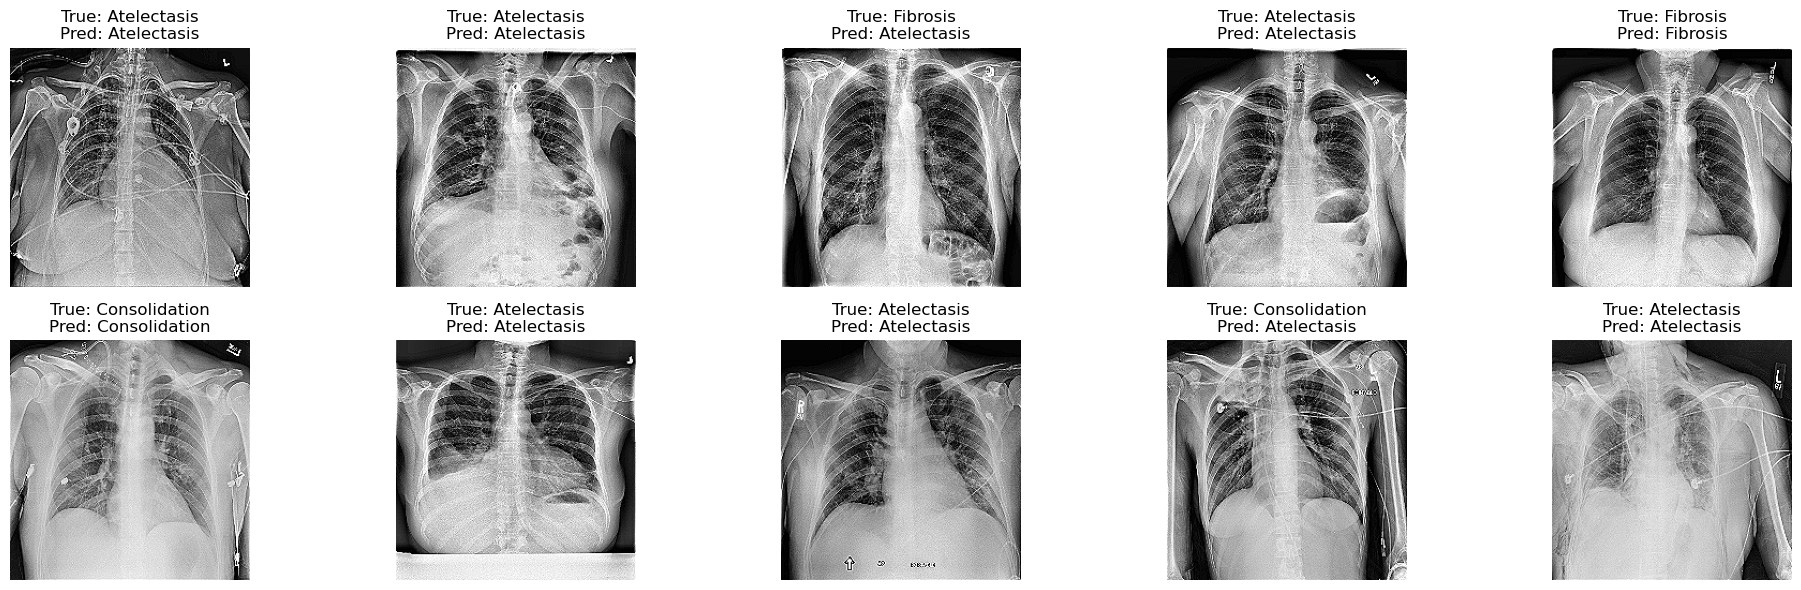

In [48]:
# === STEP 9: Evaluate Final Test Accuracy ===
loss, acc = model.evaluate(val_aug.flow(X_test, y_test), verbose=1)
print(f"[RESULT] Test Accuracy: {acc:.4f}, Loss: {loss:.4f}")



def show_test_images(X, y, model, target_classes, num_images=6):
    if num_images > 10:
        print("Limiting to 10 images max.")
        num_images = 10

    rows = 2
    cols = (num_images + 1) // 2  # ensures upper bound of 2 rows

    plt.figure(figsize=(4 * cols, 6))

    for i in range(num_images):
        idx = np.random.randint(0, len(X))
        img = X[idx]
        true_label = np.argmax(y[idx])

        # Predict
        prediction = model.predict(np.expand_dims(img, axis=0), verbose=0)
        pred_label = np.argmax(prediction)

        # Plot
        plt.subplot(rows, cols, i + 1)
        plt.imshow(cv2.cvtColor(img.astype(np.float32), cv2.COLOR_BGR2RGB))
        plt.title(f"True: {target_classes[true_label]}\nPred: {target_classes[pred_label]}")
        plt.axis('off')
b
    plt.tight_layout()
    plt.show()



show_test_images(X_test, y_test, model, target_labels, 10)

In [49]:
model.save('model_ACEF.h5')

In [50]:
from sklearn.metrics import roc_auc_score

# Predict probabilities for each class
y_pred_probs = model.predict(X_test, verbose=0)  # shape: (n_samples, n_classes)

# y_test should be one-hot encoded, which it already is in your case
# y_pred_probs are the predicted probabilities

# Compute ROC AUC using one-vs-rest (macro average)
auc_score = roc_auc_score(y_test, y_pred_probs, multi_class='ovr', average='macro')

print(f"[RESULT] ROC AUC Score (macro-averaged OvR): {auc_score:.4f}")


[RESULT] ROC AUC Score (macro-averaged OvR): 0.8799


<Figure size 800x600 with 0 Axes>

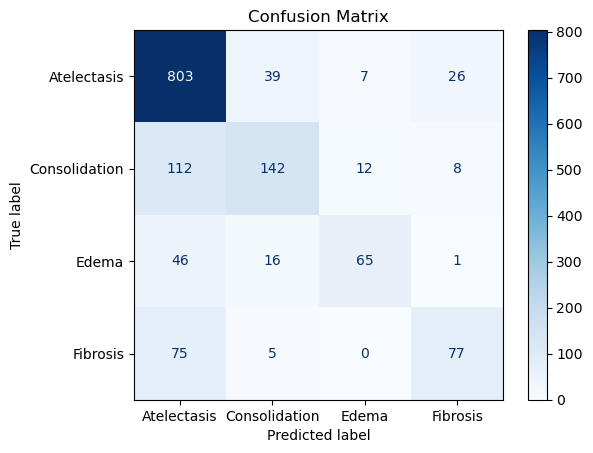

In [51]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# Convert one-hot labels to class indices
y_true = np.argmax(y_test, axis=1)

# Get predicted class indices from model
y_pred = np.argmax(model.predict(X_test, verbose=0), axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_labels)
plt.figure(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.show()


In [109]:
from sklearn.metrics import classification_report
import numpy as np

# Convert one-hot to class indices
y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(model.predict(X_test, verbose=0), axis=1)

# Generate classification report
report = classification_report(y_true, y_pred, target_names=target_labels, digits=4)
print("Classification Report:\n")
print(report)


Classification Report:

               precision    recall  f1-score   support

  Atelectasis     0.7428    0.9089    0.8175       626
Consolidation     0.6577    0.4900    0.5616       200
        Edema     0.6122    0.3261    0.4255        92
     Fibrosis     0.6250    0.3636    0.4598       110

     accuracy                         0.7169      1028
    macro avg     0.6594    0.5222    0.5661      1028
 weighted avg     0.7020    0.7169    0.6944      1028



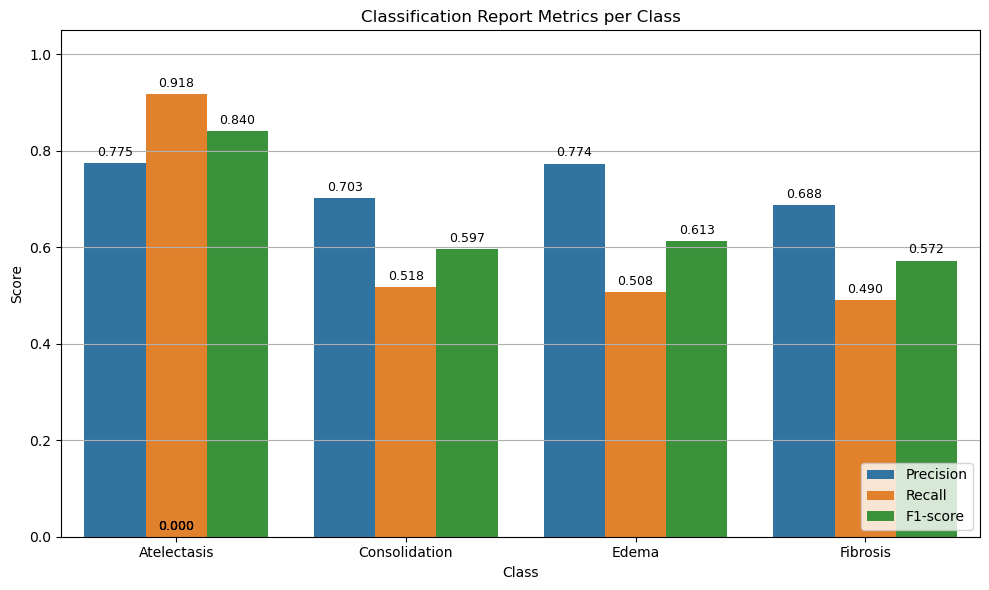

In [60]:
from sklearn.metrics import precision_recall_fscore_support
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Convert one-hot to class indices
y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(model.predict(X_test, verbose=0), axis=1)

# Extract precision, recall, f1-score
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred)

# Create DataFrame
df_report = pd.DataFrame({
    'Class': target_labels,
    'Precision': precision,
    'Recall': recall,
    'F1-score': f1
})

# Melt for easier plotting
df_melted = df_report.melt(id_vars='Class', var_name='Metric', value_name='Score')

plt.figure(figsize=(10, 6))
barplot = sns.barplot(data=df_melted, x='Class', y='Score', hue='Metric')
plt.title('Classification Report Metrics per Class')
plt.ylim(0, 1.05)
plt.legend(loc='lower right')
plt.grid(axis='y')
plt.tight_layout()

# Annotate each bar with the score (formatted as 0.###)
for p in barplot.patches:
    height = p.get_height()
    if np.isnan(height):
        continue
    barplot.annotate(f'{height:.3f}', 
                     (p.get_x() + p.get_width() / 2., height),
                     ha='center', va='bottom', fontsize=9, rotation=0, xytext=(0, 3),
                     textcoords='offset points')

plt.show()
